# Fit a REML GAM as a REML GLMM with MixedEffects.jl

In [1]:
library(tictoc)

In [2]:
tic()
suppressPackageStartupMessages({
    library(gamm4)
    library(arrow)
    library(dplyr)
    library(arrow)
    library(gratia)
    library(base64enc)
    library(jsonlite)
    library(reticulate)
    library(mgcViz)
    library(MASS)
})
toc()

1.074 sec elapsed


In [3]:
experiment_name <- "gammJ_devel-R-subsample-v8_je_ecm"
model_fname <- paste0(experiment_name, "_gam_model.RData")
plot_fname <- paste0(experiment_name, "_gam_plot_data.RData")
julia_fname <- paste0(experiment_name, "_gam_julia_data.json")

In [4]:
tic()

In [5]:
set.seed(2024)

In [6]:
tic()
data <- read_parquet("/home/aschneuwl/workspace/agecon-thesis/notebooks/02_models/30_base_data_september_JE.parquet")
toc()

1.511 sec elapsed


In [7]:
data$year <- as.factor(data$year)

In [8]:
data <- droplevels(data)

In [9]:
# Define a function that takes the dataframe and a threshold as arguments
sample_farms_until_threshold <- function(dataframe, threshold) {
  # Get all unique farm IDs and shuffle the list of unique farms
  unique_farms <- unique(dataframe$farmIdLocationSample)
  shuffled_farms <- sample(unique_farms)  # This shuffles the unique farm IDs
  
  # Initialize an empty data frame to store the selected samples
  selected_samples <- data.frame()
  
  # Initialize the total number of samples collected
  total_samples <- 0
  
  # Loop through the shuffled farms and add samples from each farm until the threshold is reached
  for (farm_id in shuffled_farms) {
    # Extract all samples for the current farm
    farm_samples <- dataframe[dataframe$farmIdLocationSample == farm_id, ]
    
    # Add the number of samples from this farm to the total count
    total_samples <- total_samples + nrow(farm_samples)
    
    # Append these farm samples to the selected_samples data frame
    selected_samples <- rbind(selected_samples, farm_samples)
    
    # Check if we have reached the threshold
    if (total_samples >= threshold) {
      break  # Stop once we have reached the threshold
    }
  }
  
  # Return the resulting dataframe with selected samples
  return(selected_samples)
}

In [10]:
tic()
df_subsample <- sample_farms_until_threshold(data, 200000)
rm(data)
toc()

130.244 sec elapsed


In [11]:
tic()
df_subsample <- droplevels(df_subsample)
toc()

0.04 sec elapsed


In [12]:
nrow(df_subsample)

[1] 200234

In [13]:
gamm4_formula = milk_ecm ~ 1 + s(thi_mean_t0_3d) + s(days_in_milk) + parity + year
gamm4_random= ~((1 | zip_month) + (1 | farmIdLocationSample) + (1 | animalId))
gamm4_family=gaussian()
gamm4_data=df_subsample
gamm4_weights=NULL
gamm4_subset=NULL
gamm4_knots=NULL
gamm4_drop.unused.levels=TRUE
gamm4_REML=TRUE
gamm4_control=lmerControl(calc.derivs = FALSE, optimizer = "bobyqa", optCtrl = list())
gamm4_start=NULL
gamm4_verbose=10

In [14]:
# Extract variable names of random effects
if (!is.null(gamm4_random)) {
    if (!inherits(gamm4_random,"formula")) stop("gamm4 requires `random' to be a formula")
    random.vars <- all.vars(gamm4_random)
  } else random.vars <- NULL

In [15]:
random.vars

[1] "zip_month"            "farmIdLocationSample" "animalId"

In [16]:
# create model frame.....
# this takes the model formula interpetes the smooth part and splits it from the pure parametric part. the parametric parts will be first, followed by the smooths
gam_params <- interpret.gam(gamm4_formula) 

In [17]:
gam_model_frame <- model.frame(formula=gam_params$fake.formula,
                           data=gamm4_data,
                           REML=NULL,
                           verbose=NULL,
                           control=NULL,,
                           start=NULL,
                           family=NULL,
                           scale=NULL,
                           knots=NULL,
                           random=NULL,
                           drop.unused.levels=gamm4_drop.unused.levels)

In [18]:
gam.terms <- attr(gam_model_frame,"terms") # terms object for `gam' part of fit -- need this for prediction to work properly

In [19]:
tic()
# checks if model has random effects
if (length(random.vars)) {
    # create model frame for the mixed effects model - but only if there are random effects
    model_formula <- as.formula(paste(paste(deparse(gam_params$fake.formula, backtick = TRUE), collapse = ""), "+", paste(random.vars, collapse = "+")))
    print(model_formula)
    lmm_model_frame <- model.frame(formula=model_formula,
                           data=gamm4_data,
                           REML=NULL,
                           verbose=NULL,
                           control=NULL,,
                           start=NULL,
                           family=NULL,
                           scale=NULL,
                           knots=NULL,
                           random=NULL,
                           drop.unused.levels=gamm4_drop.unused.levels)
} else lmm_model_frame <- gam_model_frame
rm(gam_model_frame)

# check the number of datapoints
if (nrow(lmm_model_frame)<2) {
    stop("Not enough (non-NA) data to do anything meaningful")
    }
toc()

milk_ecm ~ parity + year + thi_mean_t0_3d + days_in_milk + zip_month + 
    farmIdLocationSample + animalId
0.028 sec elapsed


In [20]:
# create variable summary for the mgcv library
tic()
vars <- all.vars(gam_params$fake.formula[-2]) ## drop dependent variable (y) here
dl = as.list(gamm4_data[,vars])
var.summary <- mgcv:::variable.summary(gam_params$pf,dl,nrow(lmm_model_frame)) ## summarize the input data
rm(dl)
toc()

0.012 sec elapsed


In [21]:
#mvars <- vars[!vars%in%names(lmm_model_frame)] ## variables not in mf raw -- can cause lmer problem
#if (length(mvars)>0) for (i in 1:length(mvars)) mf[[mvars[i]]] <- dl[[mvars[i]]] ## append raw versions to mf

In [22]:
# Fixed Effect model frame without the smooth terms and random effects
tic()
pmf <- model.frame(formula=gam_params$pf,
                           data=gamm4_data,
                           REML=NULL,
                           verbose=NULL,
                           control=NULL,
                           start=NULL,
                           family=NULL,
                           scale=NULL,
                           knots=NULL,
                           random=NULL,
                           drop.unused.levels=gamm4_drop.unused.levels)
toc()

0.014 sec elapsed


In [23]:
gam_params$pf

milk_ecm ~ parity + year

In [24]:
p_terms <- attr(pmf,"terms")

In [25]:
# Decision LMM or GLMM
if (is.character(gamm4_family)) gamm4_family<-eval(parse(text=family))
if (is.function(gamm4_family)) gamm4_family <- family()
if (is.null(gamm4_family$family)) stop("family not recognized")
if (gamm4_family$family == "gaussian" && gamm4_family$link == "identity") is_lmm <- TRUE else is_lmm <- FALSE

In [26]:
is_lmm

[1] TRUE

# Prepare matrices for smooth terms

In [27]:
tic()
G <- mgcv:::gam.setup(gam_params,p_terms,
                 data=lmm_model_frame,knots=gamm4_knots,sp=NULL, min.sp=NULL,H=NULL,absorb.cons=TRUE,sparse.cons=0,gamm.call=TRUE)
toc()

2.215 sec elapsed


In [28]:
names(G)

[1] "m"             "min.sp"        "pearson.extra" "dev.extra"    
 [5] "n.true"        "pterms"        "intercept"     "nsdf"         
 [9] "contrasts"     "xlevels"       "assign"        "smooth"       
[13] "S"             "off"           "cmX"           "X"            
[17] "sp"            "rank"          "n.paraPen"     "lsp0"         
[21] "y"             "n"             "w"             "term.names"

In [29]:
if (!is.null(G$L)) {
    stop("gammJ can not handle linked smoothing parameters (probably from use of `id' or adaptive smooths)")
}

In [30]:
first.f.para <- G$nsdf+1 # number of parametric, non-smooth, model terms including the intercept + 1

random_effects <- list()

# create index selector for all fixed effect terms including the incercept in the G$X matrix (this does not include the fixed effect terms generated for the smooth)
if (G$nsdf>0) {
    ind <- 1:G$nsdf
} else {
    ind <- rep(0,0)
}

# create sparse fixed effect matrix with the index selector created above
X <- G$X[,ind,drop=FALSE] # accumulate fixed effects into here
xlab <- rep("",0)
G$Xf <- as(X,"dgCMatrix") ## sparse version of full matrix, treating smooths as fixed

first.para <- G$nsdf+1

used.names <- names(lmm_model_frame) ## keep track of all variable names already used

In [31]:
names(G$smooth[[1]])

[1] "term"           "bs.dim"         "fixed"          "dim"           
 [5] "p.order"        "by"             "label"          "xt"            
 [9] "id"             "sp"             "drop.null"      "S"             
[13] "UZ"             "Xu"             "df"             "shift"         
[17] "rank"           "null.space.dim" "plot.me"        "side.constrain"
[21] "repara"         "S.scale"        "vn"             "first.para"    
[25] "last.para"      "first.sp"       "last.sp"

In [32]:
tic()
## work through the smooths (G$m is the number of smooth terms)
## sm stands for smooth term
if (G$m) for (i in 1:G$m) {
    
    # get the parameters for smooth
    sm <- G$smooth[[i]] 

    # get corresponding column indexed for the fixed effect matrix
    sm_fixed_start_idx <- sm$first.para
    sm_fixed_stop_idx <- sm$last.para

    # create sparse matrix X in smooth term with the corresponding fixed effect matrix columns
    sm$X <- G$X[,sm_fixed_start_idx:sm_fixed_stop_idx,drop=FALSE]

    ## convert smooth to random effect and fixed effects (mixed effecgt model smooth)
    rand_smooth <- mgcv::smooth2random(sm,used.names,type=2) 
    used.names <- c(used.names,names(rand_smooth$rand))    

    # fixed boolean (is the smooth penalized or not)
    sm$fixed <- rand_smooth$fixed

    # handle fixed effect matrix if smooth comes with "by" interaction
    ## deal with creation of sparse full model matrix when the smooth term is split by group variable ("by")
    ## when by is used then object$fac is created --> smooth.r in the MGCV library
    if (!is.null(sm$fac)) {
      # factor levels for smooth according to the "by" argument (no interaction)
      flev <- levels(sm$fac) ## grouping factor for smooth
      # number of factor levels
      n.lev <- length(flev)  
      for (k in 1:n.lev) {
        G$Xf <- cbind2(G$Xf,as(sm$X*as.numeric(sm$fac==flev[k]),"dgCMatrix"))
      }
    } else {
    # no "by" argument in the smooth (no interaction)
      n.lev <- 1
      G$Xf <- cbind2(G$Xf,as(sm$X,"dgCMatrix"))
    }
    
    ## now append random effects to main list
    n.para <- 0 ## count random coefficients of all random components of the smooth (number of parameters for the current smooth term)
    #rinc <- rind <- rep(0,0)
    if (!sm$fixed) {
    # random effect component of smooth if it is penalized (unpenalized smooths are pure regression splines and don't have a random component)
      for (k in 1:length(rand_smooth$rand)) {
          # number of random components of the smooth
          n.para <- n.para + ncol(rand_smooth$rand[[k]])
      }
      
      # name of the smooth
      sm$lmer.name <- names(rand_smooth$rand)
      # append to list of Z
      random_effects <- c(random_effects,rand_smooth$rand)
      # reverse transformations
      sm$trans.D <- rand_smooth$trans.D
      sm$trans.U <- rand_smooth$trans.U ## matrix mapping fit coefs back to original
    }
    
    ## ensure stored first and last para relate to G$Xf in expanded version
    sm$last.para <- first.para + ncol(rand_smooth$Xf) + n.para - 1
    sm$first.para <- first.para
    first.para <- sm$last.para + 1    

    ## Smooth term fixed effect matrix labels
    if (ncol(rand_smooth$Xf)) {
      Xfnames <- rep("",ncol(rand_smooth$Xf)) 
      k <- length(xlab)+1
      for (j in 1:ncol(rand_smooth$Xf)) {
        xlab[k] <- Xfnames[j] <-
        new.name(paste(sm$label,"Fx",j,sep=""),xlab)
        k <- k + 1
      } 
      colnames(rand_smooth$Xf) <- Xfnames
      sm$xf_smooth_names <- Xfnames
    }
    
    X <- cbind(X,rand_smooth$Xf) # add fixed model matrix to overall fixed X
    
    sm$first.f.para <- first.f.para
    first.f.para <- first.f.para + ncol(rand_smooth$Xf)
    sm$last.f.para <- first.f.para - 1 ## note less than sm$first.f.para => no fixed
    
    ## store indices of random parameters in smooth specific array
    sm$rind <- rand_smooth$rind 
    sm$rinc <- rand_smooth$rinc 
    
    sm$pen.ind <- rand_smooth$pen.ind ## pen.ind==i TRUE for coef penalized by ith penalty
    
    sm$n.para <- n.para
    
    sm$X <- NULL ## delete model matrix
    
    G$smooth[[i]] <- sm  ## replace smooth object with extended version 
}

G$random <- random_effects ## named list of random effect matrices
G$X <- X
toc()

0.098 sec elapsed


In [33]:
G$var.summary <- var.summary

In [34]:
if (is.null(gamm4_random)&&n.sr==0) 
  stop("gamm4 models must have at least 1 smooth with unknown smoothing parameter or at least one other random effect")

In [35]:
offset.name <- attr(lmm_model_frame,"names")[attr(attr(lmm_model_frame,"terms"),"offset")]

## Add updated data to model frame

In [36]:
# add y to the model.frame
yname <- new.name("y",names(lmm_model_frame))
eval(parse(text=paste("lmm_model_frame$",yname,"<-G$y",sep="")))

## add constructed X to the model.frame
Xname <- new.name("X",names(lmm_model_frame))
eval(parse(text=paste("lmm_model_frame$",Xname,"<-G$X",sep="")))

In [37]:
# add each random smooth component to the model frame
n_random_smooth_c <- length(G$random)
random_smooth_c_names <- names(G$random)
if (n_random_smooth_c){
    for (i in 1:n_random_smooth_c) { 
        lmm_model_frame[[random_smooth_c_names[i]]] <- factor(rep(1:ncol(G$random[[i]]),length=nrow(G$random[[i]])))
    }
}

### Construct LME4 formula

In [38]:
#the intercept is excluded from the mixed model formula because its already included in the fixed effect matrix X
lme4.formula <- paste(yname,"~",Xname,"-1") 

# add offset variables
if (length(offset.name)) {
    lme4.formula <- paste(lme4.formula,"+",offset.name) 
}

## append the regular random effects
if (!is.null(gamm4_random)) { 
    lme4.formula <- paste(lme4.formula,"+",
                substring(paste(deparse(gamm4_random,backtick=TRUE),collapse=""),first=2))
}

# add each random smooth component to the model formula
random_smooth_c_names <- names(G$random)
if (n_random_smooth_c){
    for (i in 1:n_random_smooth_c) { 
        lme4.formula <- paste(lme4.formula,"+ (1|",random_smooth_c_names[i],")")
    }
}



In [39]:
lme4.formula <- as.formula(lme4.formula)

In [40]:
lme4.formula

y ~ X - 1 + ((1 | zip_month) + (1 | farmIdLocationSample) + (1 | 
    animalId)) + (1 | Xr) + (1 | Xr.0)

In [41]:
tic()
if (is_lmm) {
    b <- lFormula(lme4.formula,data=lmm_model_frame,weights=G$w,REML=gamm4_REML,control=gamm4_control)
        } else { 
    b <- glFormula(lme4.formula,data=mf,family=gamm4_family,weights=G$w,control=gamm4_control)
}
toc()

2.258 sec elapsed


## Prepare data to pass over to Julia via JSON
currently over files --> could use JuliaCall later on

In [42]:
library(arrow)
library(base64enc)

In [43]:
arrow_base64 <- function(data) {
    buffer_output <- BufferOutputStream$create()
    
    # Write the data frame to the Parquet format in the buffer
    write_parquet(data, sink = buffer_output, compression = "snappy")
    
    # Get the raw binary data from the buffer
    raw_data <- buffer_output$finish()$data()
    
    # Encode the binary data to Base64
    base64_encoded <- base64encode(raw_data)

    return(base64_encoded)
}

In [44]:
base64_to_dataframe <- function(base64_string) {
  # Decode the Base64 string to raw binary data
  raw_data <- base64decode(base64_string)
  
  # Create a BufferReader from the raw binary data
  buffer_input <- BufferReader$create(raw_data)
  
  # Read the data frame from the Parquet format in the buffer
  data <- read_parquet(buffer_input)

  data <- as.data.frame(data)
  
  return(data)
}

In [45]:
tic()
julia_data = list()

# dependent variable
julia_data$y <- NULL
julia_data["weights"] <- arrow_base64(as.data.frame(G$w))

# smooths metadata
julia_data$smooths_data <- list()
julia_data$smooths_data$mixed_model_refs <- list()
#julia_data$smooths_data$smooths <- list()

# fixed effects data
julia_data$fixed_effect_data <- list()

# random effects data
julia_data$random_effects_data <- list() 

# smooth term random effects data
julia_data$random_effects_data$smooths <- list()
julia_data$random_effects_data$smooths$group_names <- names(G$random)
julia_data$random_effects_data$smooths$z <- list()
julia_data$random_effects_data$smooths$groups <- list()

# regular random effects data
julia_data$random_effects_data$regular <- list()
julia_data$random_effects_data$regular$group_names <- setdiff(names(b$reTrms$cnms), random_smooth_c_names)
julia_data$random_effects_data$regular$cnames <- list()
julia_data$random_effects_data$regular$groups <- list()

fe_x <- lmm_model_frame[["X"]]
fe_cols <- colnames(fe_x)
julia_data$fixed_effect_data$cnames <- fe_cols
julia_data$fixed_effect_data$x <- arrow_base64(as.data.frame(fe_x))

for (re_col in julia_data$random_effects_data$regular$group_names) {
    julia_data$random_effects_data$regular$groups[[re_col]] = arrow_base64(lmm_model_frame[re_col])
    julia_data$random_effects_data$regular$cnames[[re_col]] = b$reTrms$cnms[[re_col]]
}

for (re_col in names(G$random)) {
    julia_data$random_effects_data$smooths$z[[re_col]] = arrow_base64(as.data.frame(G$random[re_col]))
    julia_data$random_effects_data$smooths$groups[[re_col]] = arrow_base64(lmm_model_frame[re_col])
    julia_data$random_effects_data$smooths$cnames[[re_col]] =  attr(G$random[[re_col]],"s.label") #b$reTrms$cnms[[re_col]]
}

julia_data$y <- arrow_base64(lmm_model_frame["y"])

for (i in 1:G$m) {
    smooth_label <- G$smooth[[i]]$label
    julia_data$smooths_data$smooths[[i]] <- smooth_label
    
    xf_groups <- G$smooth[[i]]$lmer.name
    xf_names <- G$smooth[[i]]$xf_smooth_names
    julia_data$smooths_data$mixed_model_refs[[smooth_label]] <- list()
    julia_data$smooths_data$mixed_model_refs[[smooth_label]][["xf_groups"]] <- xf_groups
    julia_data$smooths_data$mixed_model_refs[[smooth_label]][["xf_names"]] <- xf_names
}
toc()

0.274 sec elapsed


In [46]:
julia_data$random_effects_data$smooths$group_names

[1] "Xr"   "Xr.0"

In [47]:
tic()
#write_json(julia_data, auto_unbox=TRUE, path = julia_fname)
toc()

0.001 sec elapsed


In [48]:
lme4.formula

y ~ X - 1 + ((1 | zip_month) + (1 | farmIdLocationSample) + (1 | 
    animalId)) + (1 | Xr) + (1 | Xr.0)

# Fitting with replacing Z for Smooths (Fabian Scheipl's Trick) - (with LME4 - for testing and comparing)

In [49]:
tic()
## Fabian Scheipl's trick of overwriting dummy slots revised for new structure
if (is_lmm) {
    b <- lFormula(lme4.formula,data=lmm_model_frame,weights=G$w,REML=gamm4_REML,control=gamm4_control)
        } else { 
    b <- glFormula(lme4.formula,data=mf,family=gamm4_family,weights=G$w,control=gamm4_control)
}
toc()

1.892 sec elapsed


In [50]:
tic()
if (n_random_smooth_c) {
    #Get summary of the existing sparse matrix
    sparse_summary <- as.data.frame(summary(b$reTrms$Zt))
    sparse_dims <- dim(b$reTrms$Zt)
    
    z_var_names <- names(b$reTrms$cnms) # variable names associated with columns of then random effect matrix Z
    z_var_names_idx <- 1:length(z_var_names) # index for each variable name above
    z_smooth_names <- names(G$random) # variable names associated with the random components generated for smooths

    ## loop through random effect smooths and ingest them into Z
    for (i in 1:n_random_smooth_c) {
        print(i)
        k <- z_var_names_idx[z_smooth_names[i]==z_var_names] ## which term (variable) name represents random smooth i

        # Step 1: Extract indices and values from the transposed matrix
        indices <- which(t(G$random[[i]]) != 0, arr.ind = TRUE)
        values <- t(G$random[[i]])[indices]
        
        # Step 2: Create dense summary DataFrame
        dense_summary <- data.frame(i = indices[, 1], j = indices[, 2], x = values)
        
        # Adjust row indices according to b$reTrms$Gp[k]
        dense_summary$i <- dense_summary$i + b$reTrms$Gp[k]
        
        # Remove rows from sparse_summary that have the same (i, j) as in dense_summary
        filtered_sparse_summary <- sparse_summary[!paste(sparse_summary$i, sparse_summary$j) %in% paste(dense_summary$i, dense_summary$j), ]
        
        # Step 4: Combine the filtered sparse summary with the dense summary
        combined_summary <- rbind(filtered_sparse_summary, dense_summary)

        sparse_summary <- combined_summary
        
        # Step 5: Determine the new dimensions of the sparse matrix
        #nrow_combined <- max(combined_summary$i)
        #ncol_combined <- max(combined_summary$j)
              
       #ii <- (b$reTrms$Gp[k]+1):b$reTrms$Gp[k+1] # get  column indices of random effect matrix belonging to that smooth
       #b$reTrms$Zt[ii,] <- as(t(G$random[[i]]),"dgCMatrix") # ingest the corresponding random effect matrix
       b$reTrms$cnms[[k]] <- attr(G$random[[i]],"s.label") 
     }
    
    # Create the new sparse matrix
    new_sparse_mat <- sparseMatrix(
          i = sparse_summary$i,
          j = sparse_summary$j,
          x = sparse_summary$x,
          dims = c(sparse_dims[1], sparse_dims[2])
        )
        
    # Step 6: Assign row and column names from the original matrix
    rownames(new_sparse_mat) <- rownames(b$reTrms$Zt)
    colnames(new_sparse_mat) <- colnames(b$reTrms$Zt)
    
    b$reTrms$Zt <- new_sparse_mat
}
toc()

[1] 1
[1] 2
12.569 sec elapsed


In [51]:
tic()
## now do the actual fitting...
ret <- list()
#arg <- list(...)
#arg <- arg[!(names(arg) %in% names(b))]
#b <- c(b,arg) ## add '...' arguments for use with do.call
b$control <- gamm4_control; b$verbose=gamm4_verbose; b$start=gamm4_start
if (is_lmm) {
    ## Create the deviance function to be optimized:
    devfun <- do.call(mkLmerDevfun, b)
    ## Optimize the deviance function:$
    opt <- optimizeLmer(devfun,start=gamm4_start,verbose=gamm4_verbose,optimizer=gamm4_control$optimizer,control=gamm4_control$optCtrl) ## previously bobyqa optimizer set, but now default
    ## Package up the results:
    ret$mer <- mkMerMod(environment(devfun), opt, b$reTrms, fr = b$fr)
} else { ## generalized case...
    ## Create the deviance function for optimizing over theta:
    devfun <- do.call(mkGlmerDevfun, b)
    ## Optimize over theta using a rough approximation (i.e. nAGQ = 0):
    opt <- optimizeGlmer(devfun,start=start,verbose=verbose,gamm4_control$optimizer,control=control$optCtrl)
    ## Update the deviance function for optimizing over theta and beta:
    devfun <- updateGlmerDevfun(devfun, b$reTrms)
    ## Optimize over theta and beta:
    opt <- optimizeGlmer(devfun, stage=2,start=start,gamm4_control$optimizer, verbose=verbose,control=control$optCtrl)
    ## Package up the results:
    ret$mer <- mkMerMod(environment(devfun), opt, b$reTrms, fr = b$fr)
}
toc()

npt = 7 , n =  5 
rhobeg =  0.2 , rhoend =  2e-07 
start par. =  1 1 1 1 1 fn =  1140381 
  1:     1140381.5:  1.00000  1.00000  1.00000  1.00000  1.00000
  2:     1141698.4:  1.20000  1.00000  1.00000  1.00000  1.00000
  3:     1142014.2:  1.00000  1.20000  1.00000  1.00000  1.00000
  4:     1140487.3:  1.00000  1.00000  1.20000  1.00000  1.00000
  5:     1140374.6:  1.00000  1.00000  1.00000  1.20000  1.00000
  6:     1140383.3:  1.00000  1.00000  1.00000  1.00000  1.20000
  7:     1139380.5: 0.800000  1.00000  1.00000  1.00000  1.00000
  8:     1137606.2: 0.719790 0.817174 0.988155  1.00076 0.999792
  9:     1134698.1: 0.599586 0.436492 0.963061  1.00240 0.999362
 10:     1148163.6: 0.428464  0.00000 0.372162 0.831090 0.795196
 11:     1136258.0: 0.442514 0.252571  1.26496  1.06472  1.07983
 12:     1136226.6: 0.536277 0.591306 0.855699 0.982637  1.00973
rho:    0.020 eval:  12 fn:  1.13470e+06 par:0.599586 0.436492 0.963061  1.00240 0.999362 
 13:     1134450.0: 0.671707 0.417723 0

In [52]:
summary(ret$mer)


Correlation matrix not shown by default, as p = 29 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML ['lmerMod']

REML criterion at convergence: 1134123

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.9421 -0.5716  0.0059  0.5855  6.8509 

Random effects:
 Groups               Name              Variance Std.Dev.
 animalId             (Intercept)        6.814   2.610   
 zip_month            (Intercept)        1.465   1.210   
 farmIdLocationSample (Intercept)       12.300   3.507   
 Xr.0                 s(days_in_milk)   87.545   9.357   
 Xr                   s(thi_mean_t0_3d)  3.167   1.780   
 Residual                               14.818   3.849   
Number of obs: 200234, groups:  
animalId, 8228; zip_month, 7395; farmIdLocationSample, 1188; Xr.0, 8; Xr, 8

Fixed effects:
                      Estimate Std. Error  t value
X(Intercept)           18.8502     0.3310   56.952
Xparityprimiparous     -3.1370     0.0245 -128.052
Xyear1999              -1.6425     0.3235   -5.077
Xyear2000              -0.6221     0.3114   -1.998
Xyear2001   

In [53]:
rm(b)

In [54]:
#julia_model_data <- fromJSON("julia_model_data.json")

In [55]:
create_br_from_julia <- function(random_effects) {
    ranefs <- list()
    re_names <- names(random_effects)
    for (re in re_names) {
        #print(random_effects[[re]])
        re_df <- base64_to_dataframe(random_effects[[re]])
        
        rownames(re_df) <- re_df[[re]]
        re_df[[re]] <- NULL
        ranefs[[re]] <- re_df
    }

    class(ranefs) <- "ranef.mer"

    return(ranefs)
}

In [56]:
#br_julia <- create_br_from_julia(julia_model_data$random_effects)

In [57]:
object<-list(model=lmm_model_frame,formula=gamm4_formula,smooth=G$smooth,nsdf=G$nsdf,family=gamm4_family,
             df.null=nrow(G$X),y=lmm_model_frame$y,
             terms=gam.terms,pterms=G$pterms,xlevels=G$xlevels,
             contrasts=G$contrasts,assign=G$assign,na.action=attr(lmm_model_frame,"na.action"),
             cmX=G$cmX,var.summary=G$var.summary)
pvars <- all.vars(delete.response(object$terms))
object$pred.formula <- if (length(pvars)>0) reformulate(pvars) else NULL

In [58]:
## to unpack coefficients look at names(ret$lme$flist), ret$lme@Zt, ranef(), fixef()

## let the GAM coefficients in the original parameterization be beta,
## and let them be beta' in the fitting parameterization. 
## Then beta = B beta'. B and B^{-1} can be efficiently accumulated
## and are useful for stable computation of the covariance matrix
## etc... 

In [59]:
# random intercepts
br <- lme4::ranef(ret$mer, condVar=FALSE) ## a named list

In [60]:
B <- as.matrix(Matrix(0,ncol(G$Xf),ncol(G$Xf)))
diag(B) <- 1
Xfp <- as.matrix(G$Xf) # fixed effect matrix with smooths as FE bases

In [61]:
## the fixed effects  -> julia betas = fixef(model) 
bf <- as.numeric(lme4::fixef(ret$mer))

In [62]:
#bf_julia <- base64_to_dataframe(julia_model_data$betas)$betas

In [63]:
first <- G$smooth[[i]]$first.f.para;
last <- G$smooth[[i]]$last.f.para

In [64]:
if (G$nsdf) {
    p <- bf[1:G$nsdf]
} else {
    p <- array(0,0) ## fixed parametric componet}
}

In [65]:
tic()
if (G$m>0) {
  # if we have smooth terms - loop over them and apply the reverse transformation
  for (i in 1:G$m) {
      fx <- G$smooth[[i]]$fixed 
      first <- G$smooth[[i]]$first.f.para # first index in fixed effect matrix
      last <- G$smooth[[i]]$last.f.para # last index in fixed effect matrix
      
      if (first <=last) {
          beta <- bf[first:last] # fetch fixed effects from trained FE matrix
          #beta <- bf_julia[first:last]
      } else { 
          beta <- array(0,0)
      }
      
      if (fx) {
          b <- beta
      } else {
          ## not fixed so need to undo transform of random effects etc. 
            b <- rep(0,0)
            for (k in 1:length(G$smooth[[i]]$lmer.name)) {
                  ## collect all coefs associated with this smooth
                  b <- c(b,as.numeric(br[[G$smooth[[i]]$lmer.name[k]]][[1]]))
                  ## b <- c(b,as.numeric(br_julia[[G$smooth[[i]]$lmer.name[k]]][[1]]))
            }
            
            b <- b[G$smooth[[i]]$rind] ## make sure coefs are in order expected by smooth
            b <- c(b,beta) 
            b <- G$smooth[[i]]$trans.D*b
            
            if (!is.null(G$smooth[[i]]$trans.U)) {
                b <- G$smooth[[i]]$trans.U%*%b ## transform back to original
            }
      }
      p <- c(p,b)
     
      ## now fill in B...
      ind <- G$smooth[[i]]$first.para:G$smooth[[i]]$last.para
      if (!fx) { 
         D <- G$smooth[[i]]$trans.D
         if (is.null(G$smooth[[i]]$trans.U)) {
             B[ind,ind] <- Diagonal(length(D),D)
         } else {
             B[ind,ind] <- t(D*t(G$smooth[[i]]$trans.U))
         }
      }
      ## and finally transform G$Xf into fitting parameterization...
      Xfp[,ind] <- as.matrix(G$Xf[,ind,drop=FALSE]%*%B[ind,ind,drop=FALSE])  # --> bottleneck
    }
}
toc()

0.081 sec elapsed


In [66]:
object$coefficients <- p

## need to drop smooths from Zt and then
## form Z'phiZ + I \sigma^2

vr <- lme4::VarCorr(ret$mer) ## list of ranef variance components in the same order as Gp

In [67]:
#scale_julia <- julia_model_data$sigma_square

In [68]:
scale <- as.numeric(attr(vr,"sc"))^2 ## get the scale parameter
if (!is.finite(scale) || scale==1) { ## NOTE: better test???
  scale <- 1
  object$scale.estimated <- FALSE
} else {
    object$scale.estimated <- TRUE
}

In [69]:
sp <- rep(-1,n_random_smooth_c)

In [70]:
Zt <- Matrix(0,0,ncol(getME(ret$mer,"Zt")))

In [71]:
if (n_random_smooth_c==0) {
    random_smooth_c_names <- NULL ## names by which smooths are known in mer
}

In [72]:
rn <- names(vr)

In [73]:
rn

[1] "animalId"             "zip_month"            "farmIdLocationSample"
[4] "Xr.0"                 "Xr"

In [74]:
ind <- rep(0,0) ## index the non-smooth random effects among the random effects

In [75]:
length(vr)

[1] 5

In [76]:
for (i in 1:length(vr)) {
    if (is.null(n_random_smooth_c) || !rn[i]%in%random_smooth_c_names) {
        ## append non smooth r.e.s to Zt
        ## collected non-smooth indexes
        Gp <- getME(ret$mer,"Gp") ## group index ends
        ind <- c(ind,(Gp[i]+1):Gp[i+1])
      
      } else if (!is.null(random_smooth_c_names)) {
          ## extract smoothing parameters for smooth r.e.s
          ## rn is the order of random effects in the fitted model
            k <- (1:n_random_smooth_c)[rn[i]==random_smooth_c_names] ## where in original smooth ordering is current smoothing param
            if (as.numeric(vr[[i]]>0)) {
                sp[k] <- scale/as.numeric(vr[[i]]) # sigma^2 /
                #sp[k] <- scale_julia / (julia_model_data$varcorr[[rn[i]]][[1]]^2)
                #print(sp[k])
                #print(scale_julia / (julia_model_data$varcorr[[rn[i]]][[1]]^2))
            } else {
                sp[k] <- 1e10
            }
      }
}

In [77]:
sp

[1] 4.6784043 0.1692621

In [78]:
# r_post_data <- fromJSON("r_post_data.json")
# WX_julia <- as.matrix(base64_to_dataframe(r_post_data$WX))
# colnames(WX_julia) <- NULL
# XVX_julia <-  as.matrix(base64_to_dataframe(r_post_data$XVX))
# colnames(XVX_julia) <- NULL

In [79]:
if (length(ind)) { ## extract columns corresponding to non-smooth r.e.s 
  Zt <- getME(ret$mer,"Zt")[ind,] ## extracting random effects model matrix
  root.phi <- getME(ret$mer,"Lambdat")[ind,ind] ## and corresponding sqrt of cov matrix (phi) -> relative covariance factor
}

In [80]:
object$prior.weights <- G$w

In [81]:
tic()
if (is_lmm) {
  object$weights <- object$prior.weights 
  V <- Diagonal(n=length(object$weights),x=scale/object$weights) 
} else { 
 # mu <- getME(ret$mer,"mu")
 # eta <- family$linkfun(mu)
  object$weights <- ret$mer@resp$sqrtWrkWt()^2
  ## object$prior.weights*family$mu.eta(eta)^2/family$variance(mu)
  V <- Diagonal(x=1/object$weights)*scale
  #V <- Diagonal(x=scale*family$variance(mu)/object$prior.weights)
}
toc()

0.001 sec elapsed


In [82]:
scale

[1] 14.81802

In [83]:
#I + (lambda'*Zt')*(lambda'*Zt')' =  (lambda'*Zt')*(Z*lambda) + 1
#(sigma^2 / weights)*I + (lambda'*Zt')*W*(lambda'*Zt')'*sigma^2/(weight)

tic()
if (nrow(Zt)>0) {
    V <- V + crossprod(root.phi%*%Zt)*scale
    #py_ss <- import("scipy.sparse")
    #py_gb <- import("graphblas")
    #py_gb$init("suitesparse", blocking=T)

    #gb_zt <- py_gb$io$from_scipy_sparse(Zt)
    #gb_v <- py_gb$io$from_scipy_sparse(V)
    #gb_phi <- py_gb$io$from_scipy_sparse(root.phi)
    #gb_phizt <- gb_phi$mxm(gb_zt)
    #gb_v <- gb_phizt$T$mxm(gb_phizt)$apply(py_gb$binary$times, scale)$ewise_add(gb_v)$new()
    #V <- py_ss$csc_matrix(py_gb$io$to_scipy_sparse(gb_v, format="csc"))  
} ## data or pseudodata cov matrix, treating smooths as fixed now
toc()

36.778 sec elapsed


In [84]:
tic()
G$Xf <- as(G$Xf,"dgCMatrix") # matrix with smooths as fixed effect terms (spline bases) (not modified)
Xfp <- as(Xfp,"dgCMatrix") # matrix with smooths as backtransformed fixed effect terms
toc()

0.026 sec elapsed


In [85]:
# julia_post_data <- list()
# julia_post_data["Xf"] <- arrow_base64(as.data.frame(as.matrix(G$Xf)))
# julia_post_data["Xfp"] <- arrow_base64(as.data.frame(as.matrix(Xfp)))
# write_json(julia_post_data, auto_unbox=TRUE, path =  "julia_post_data.json")

In [86]:
tic()
cholmod <- import("sksparse.cholmod")
R <- cholmod$cholesky(V,0,use_long=TRUE)
toc()

39.663 sec elapsed


In [89]:
#tic()
#R_old <- Matrix::chol(V,pivot=TRUE);
#piv <- attr(R_old,"pivot")
#WX_old <- as(solve(t(R_old),Xfp),"matrix")
#XVX_old <- as(solve(t(R_old),G$Xf),"matrix")
#toc()

In [90]:
names(R)

[1] "apply_P"              "apply_Pt"             "cholesky"            
 [4] "cholesky_AAt"         "cholesky_AAt_inplace" "cholesky_inplace"    
 [7] "copy"                 "D"                    "det"                 
[10] "inv"                  "L"                    "L_D"                 
[13] "LD"                   "logdet"               "P"                   
[16] "slogdet"              "solve_A"              "solve_D"             
[19] "solve_DLt"            "solve_L"              "solve_LD"            
[22] "solve_LDLt"           "solve_Lt"             "update_inplace"

In [91]:
tic()
WX <- as.matrix(R$solve_L(Xfp,use_LDLt_decomposition=FALSE)) ## V^{-.5}Xp -- fit parameterization
#WX <- matrix_from_parquet_base64(wx_xvx_data$WX)
toc()

2.052 sec elapsed


In [92]:
tic()
#XVX <- as(solve(t(R),G$Xf),"matrix")  ## same in original parameterization 
XVX <- as.matrix(R$solve_L(G$Xf,use_LDLt_decomposition=FALSE))
#XVX <- matrix_from_parquet_base64(wx_xvx_data$XVX)
toc()

2.059 sec elapsed


In [93]:
tic()
qrz <- qr(XVX,LAPACK=TRUE)
object$R <- qr.R(qrz);
object$R[,qrz$pivot] <- object$R # when using sparse matrix
toc()

0.074 sec elapsed


In [94]:
tic()
XVX <- crossprod(object$R)
toc()

0.001 sec elapsed


In [95]:
object$sp <- sp

In [96]:
tic()
colx <- ncol(G$Xf)
Sp <- matrix(0,colx,colx) # penalty matrix - fit param
first <- G$nsdf+1
k <- 1
if (G$m>0) {
    for (i in 1:G$m) {
        # Accumulate the total penalty matrix
      if (!object$smooth[[i]]$fixed) {
        ii <- object$smooth[[i]]$first.para:object$smooth[[i]]$last.para
        ## index this smooth's params
        
        for (j in 1:length(object$smooth[[i]]$S)) {
            ## work through penalty list
            ind <- ii[object$smooth[[i]]$pen.ind == j] ## index of currently penalized
            diag(Sp)[ind] <- sqrt(object$sp[k]) ## diagonal penalty
            k <- k+1
        }
      }
      first <- last + 1 
    }
}
toc()

0.01 sec elapsed


In [97]:
tic()
## Alternative cov matrix calculation. Basic
## idea is that cov matrix is computed stably in
## fitting parameterization, and then transformed to
## original parameterization. 
qrx <- qr(as.matrix(rbind(WX,Sp/sqrt(scale))),LAPACK=TRUE)

Ri <- backsolve(qr.R(qrx),diag(ncol(WX)))
ind <- qrx$pivot;ind[ind] <- 1:length(ind)## qrx$pivot
Ri <- Ri[ind,] ## unpivoted square root of cov matrix in fitting parameterization Ri Ri' = cov
Vb <- B%*%Ri; 
Vb <- Vb%*%t(Vb)

object$edf<-rowSums(Vb*t(XVX))

object$df.residual <- length(object$y) - sum(object$edf)

object$sig2 <- scale
if (is_lmm) { 
    object$method <- "lmer.REML"
} else {
    object$method <- "glmer.ML"}

object$Vp <- as(Vb,"matrix")

object$Ve <- as(Vb%*%XVX%*%Vb,"matrix")

class(object) <- "gam"
toc()

0.125 sec elapsed


In [98]:
tic()
## Restore original smooth list, if it was split to deal with t2 terms...
if (!is.null(G$original.smooth)) {
  object$smooth <- G$smooth <- G$original.smooth
}

## If prediction parameterization differs from fit parameterization, transform now...
## (important for t2 smooths, where fit constraint is not good for component wise 
##  prediction s.e.s)

if (!is.null(G$P)) {
  object$coefficients <- G$P %*% object$coefficients
  object$Vp <- G$P %*% object$Vp %*% t(G$P) 
  object$Ve <- G$P %*% object$Ve %*% t(G$P) 
}

object$linear.predictors <- predict.gam(object,type="link")
object$fitted.values <- object$family$linkinv(object$linear.predictors)
toc()

2.414 sec elapsed


In [101]:
tic()
object$residuals <- residuals(ret$mer) 

if (G$nsdf>0) term.names<-colnames(G$X)[1:G$nsdf] else term.names<-array("",0)
n.smooth<-length(G$smooth) 
if (n.smooth)
for (i in 1:n.smooth) { 
    k<-1
  for (j in object$smooth[[i]]$first.para:object$smooth[[i]]$last.para){ 
      term.names[j]<-paste(object$smooth[[i]]$label,".",as.character(k),sep="")
      k<-k+1
  }
}

names(object$coefficients) <- term.names  # note - won't work on matrices!!
names(object$edf) <- term.names
names(object$sp) <- names(G$sp)

if (isREML(ret$mer)) {
    object$gcv.ubre <- REMLcrit(ret$mer) 
} else { 
    object$gcv.ubre <- deviance(ret$mer)
}

if (!is.null(G$Xcentre)) {
    object$Xcentre <- G$Xcentre ## any column centering applied to smooths
}

ret$gam<-object
toc()

0.014 sec elapsed


In [102]:
summary(ret$gam)


Family: gaussian 
Link function: identity 

Formula:
milk_ecm ~ 1 + s(thi_mean_t0_3d) + s(days_in_milk) + parity + 
    year

Parametric coefficients:
                  Estimate Std. Error  t value Pr(>|t|)    
(Intercept)       18.85018    0.28787   65.483  < 2e-16 ***
parityprimiparous -3.13695    0.02123 -147.748  < 2e-16 ***
year1999          -1.64253    0.31266   -5.253 1.50e-07 ***
year2000          -0.62208    0.28448   -2.187 0.028761 *  
year2001           0.97205    0.27330    3.557 0.000376 ***
year2002           1.15341    0.27476    4.198 2.69e-05 ***
year2003           1.29279    0.27261    4.742 2.12e-06 ***
year2004           2.09150    0.27153    7.703 1.34e-14 ***
year2005           2.20402    0.27006    8.161 3.34e-16 ***
year2006           2.57324    0.26899    9.566  < 2e-16 ***
year2007           2.34451    0.26861    8.728  < 2e-16 ***
year2008           2.76845    0.26797   10.331  < 2e-16 ***
year2009           2.97484    0.26780   11.108  < 2e-16 ***
year2010

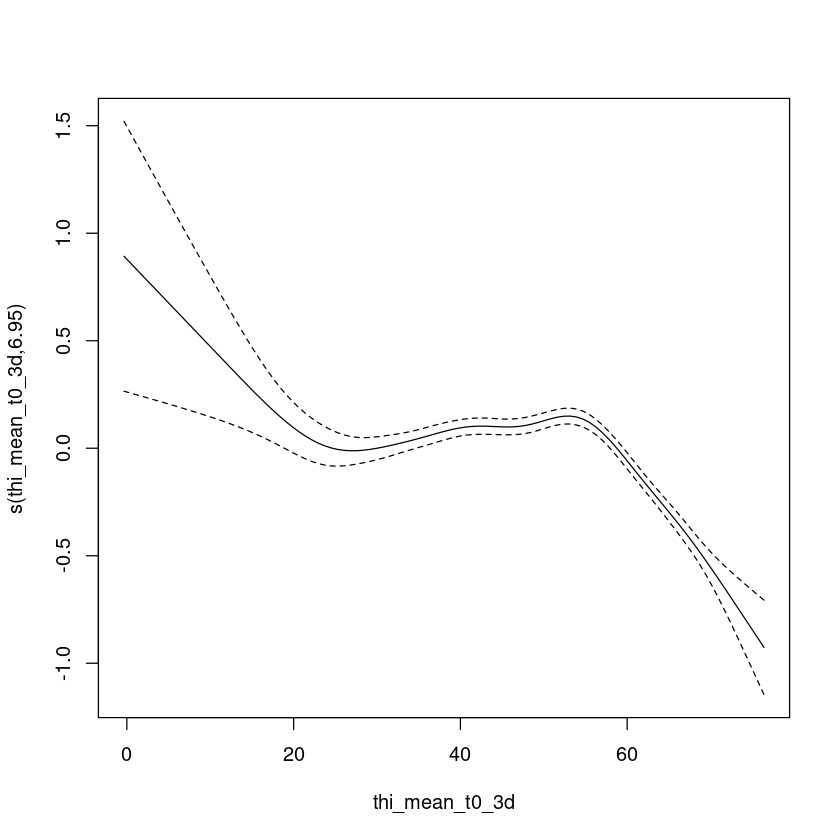

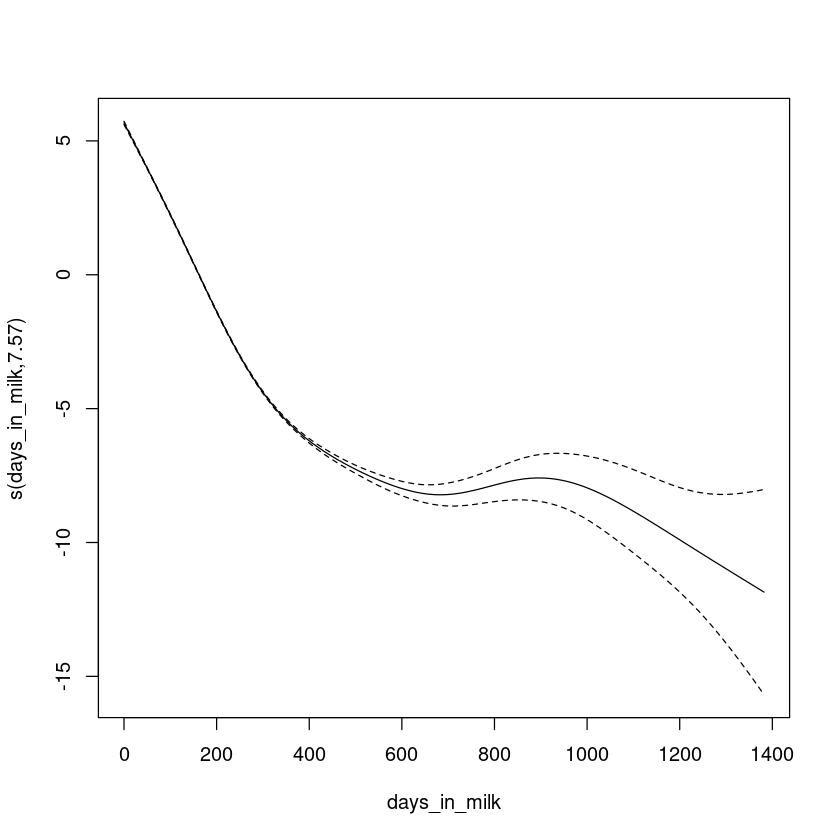

In [103]:
plot(ret$gam, scale=0)

In [104]:
b <- getViz(ret$gam)

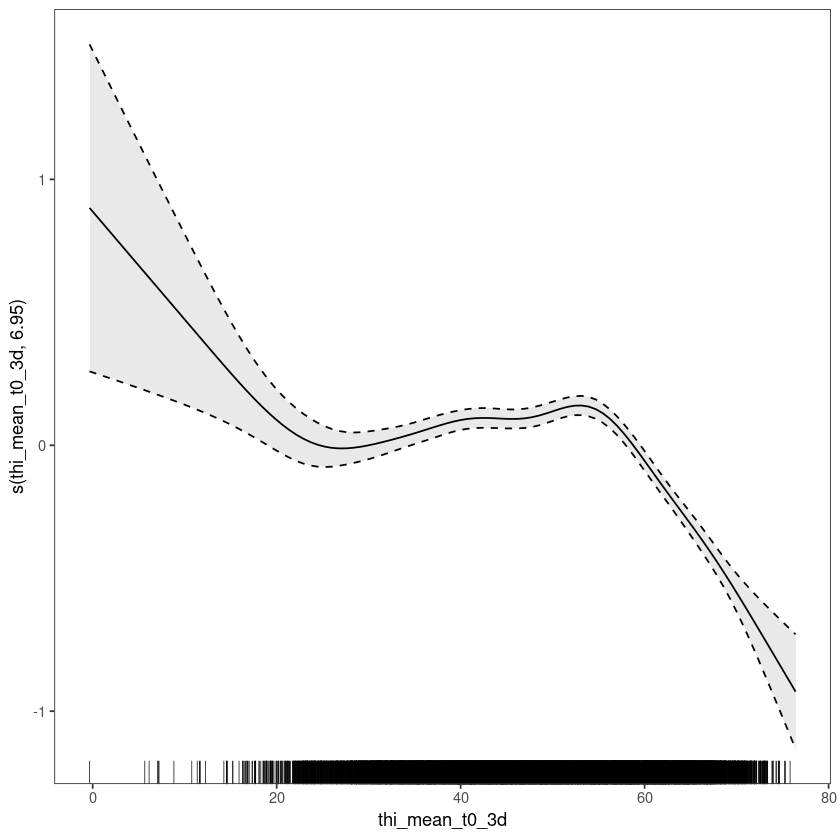

In [105]:
plot(sm(b, 1)) + 
  l_ciPoly(alpha = 0.5) +  # Add confidence interval with semi-transparency
  l_fitLine() +  # Add fitted line
  l_ciLine() +
  l_rug()# +
  #geom_vline(xintercept = 53, color = "red", linetype = "dashed", size = 1)

In [106]:
toc()

29.552 sec elapsed


In [107]:
first_derivative <- derivatives(ret$gam, type = "central", order = 1)

# Find where the first derivative changes from positive to negative
inflection_points <- with(first_derivative, {
  signs <- sign(.derivative)  # Assuming the column name for the derivative is 'derivative'
  change_points <- which(diff(signs) < 0)  # Find where the sign changes from positive to negative
  data.frame(x = first_derivative[change_points + 1,], y = ret$gam$fitted.values[change_points + 1])
})

In [108]:
inflection_points

,x..smooth,x..by,x..fs,x..derivative,x..se,x..crit,x..lower_ci,x..upper_ci,x.thi_mean_t0_3d,x.days_in_milk,y
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
57,s(thi_mean_t0_3d),NA,NA,-0.001085338,0.005385884,1.959964,-0.011641476,0.009470800,43.07129,NA,17.58726
70,s(thi_mean_t0_3d),NA,NA,-0.002080386,0.005372712,1.959964,-0.012610707,0.008449935,53.14956,NA,17.29161
166,s(days_in_milk),NA,NA,-0.000794488,0.003430647,1.959964,-0.007518433,0.005929457,NA,907.3737,22.12696


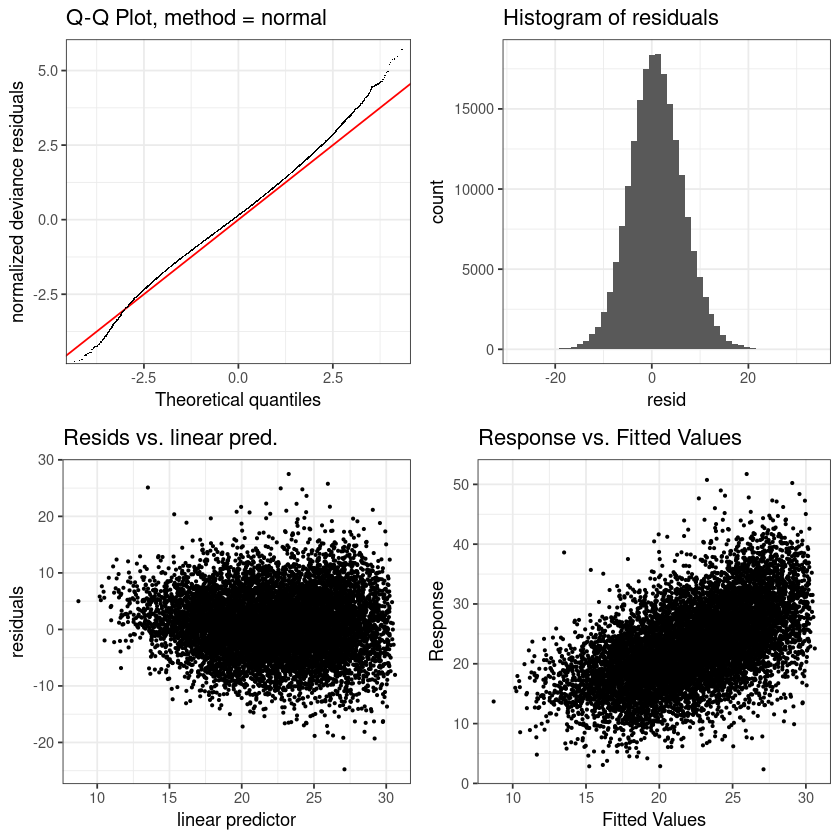

In [109]:
check(b,
      a.qq = list(method = "tnorm", 
                  a.cipoly = list(fill = "light blue")), 
      a.respoi = list(size = 0.5), 
      a.hist = list(bins = 50))

In [110]:
tic()
saveRDS(ret$gam,file=model_fname, compress="gzip")
toc()
tic()
saveRDS(b,file=plot_fname, compress="gzip")
toc()

0.869 sec elapsed
0.943 sec elapsed
